# Simiosis gia Grid
- o skopos tou na dimiourgisw ena grid einai gia na miosw kata poli to sinolo ton simion sto disance join
- auto epitinxanete ftiaxnontas ena MBB pernontas ta min ton max(x,y) kai apo ta 2 data sets kathos kai ta max apo ta min(x,y) me tin logiki oti osa simia einai ektos tou min max x enos apo ta 2 dataset den ikanopoioun tin sinthiki theta.
- stin sinexia tha prepei na kanw spatial join to grid kai me ta 2 datasets gia na vrw se poio grid paei kathe simio
- meta tha aporipsw osa grids den exoun kanena

### Xrisima stixia na periexei ena grid
- gridId
- polygon
- TODO Check id x an y needed for partitioning reasons

### Idea gia grid filtering
- Na kanw spatial join mono sto dataset me ta ligotera simia prokimenou na filtrarw ta grids pou den exeoun kanena simio apo to Dataset auto
- Me auton ton tropo epitinxanw na kanw mikrotero spatial join sto dataset me tis perisoteres eggrafes
- auto vasizete sto

# Simiosis gia partitioning
- prepei na xorisw ta data mou se ola ta mixanimata prin ksekinisw to spatial join
- episis prepei na xorisw kai ta grids omiomorfa se ola ta mixanimata
- enas tropos gia na ta xorisw tha mporouse na einai to X. Diladi na vrw ta max kai min X kai paota 2 datasets gia na vrw to rangekai na kanw range partition os pros x gia ta points
- gia ta grids apo tin all tha eprepe na kanw partition os pros to max X tous oste na simenei oti oti grid einai sto partition exei points mono sto partition auto.
- me auton ton tropo epitinxanoume na exoume ta points kai ta grids tous mirasmena ana mixanima kai na empodisoume tis metakinisis sto diktio

### Pws to kanw auto?
- prepei na dw pws douleui to pratitioning
- pos simperiferete to join sto partitioning
- prepei na dw an ipostirizei kati tetoio i vivliothiki

## Imports

In [1]:
# Main  Imports
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.core.display import display
import time

# Local App Imports
from utils import spatialUtils as utils

# Spark Imports
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DataType


# Sedona Imports
from sedona.utils import KryoSerializer, SedonaKryoRegistrator
from sedona.register import SedonaRegistrator
from sedona.sql.types import GeometryType

# Python shapely imports
import shapely.geometry as sg
from descartes import PolygonPatch
import geog
import shapely.speedups
shapely.speedups.enable() # this makes some spatial queries run faster

## Load Dataset

In [2]:
# full program timer
total_time = time.time()

test_sample_A_path = "../testData/ais_one_hour.csv"
test_sample_B_path = "../testData/ais_one_hour2.csv"

# test_sample_path = "../testData/ais_one_month.csv"


# create sedona spark session
spark = SparkSession. \
    builder. \
    appName('appName'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.0-incubating,'
           'org.datasyslab:geotools-wrapper:geotools-24.0'). \
    getOrCreate()

SedonaRegistrator.registerAll(spark)

# Load CSV File
df_a = spark.read.csv(header="True", inferSchema="True", path=test_sample_A_path)
df_a.show(10)

+---+--------------------+----------+---------+
|_c0|                 _id|         X|        Y|
+---+--------------------+----------+---------+
|  0|60039bef2bc024099...|  -4.50088| 48.35698|
|  1|60039b8f2bc024099...|-4.4970617|48.379555|
|  2|60039b9c2bc024099...|-4.4137635| 48.15062|
|  3|60039bef2bc024099...| -4.500963|48.356915|
|  4|60039bbe2bc024099...| -4.474253|48.341007|
|  5|60039bef2bc024099...| -4.501045|48.356842|
|  6|60039a6c2bc024099...| -4.497015|48.382206|
|  7|60039c032bc024099...|  -4.56926| 48.13976|
|  8|60039e032bc024099...| -4.476655| 48.38109|
|  9|60039bef2bc024099...| -4.501128|48.356773|
+---+--------------------+----------+---------+
only showing top 10 rows



## Filter Dataset for Test Reasons
- arxika tha periorisoume to dataset stin perioxi x[-6.5,-5] kai y[47.5,49]
- epilegw auto gt kserw oti exei arketa pings

df_a = df_a.filter( (-6.5 <= df_a.X) & (df_a.X <= -5) & (47.5 <= df_a.Y) & (df_a.Y <= 49))
print("Total filtered_df_a count {}".format(df_a.count()))
df_a.show(10)

## Map Point objects
Create shapely poit object for each ping


## Grid Dataset
Lets create a test grid
- We have to finde the MBB of the dataset
- Then we have to create a grid for this dataset (**sos** each grid side has to be equal to theta)

In [3]:
cell_time = time.time()

# find min/max X,Y from dataset
mbb_row = df_a.agg(
    F.max(df_a.X),
    F.min(df_a.X),
    F.max(df_a.Y),
    F.min(df_a.Y),
).collect()[0]
print("print mbb: {}".format(mbb_row))

#calculate grid for dataset
grid = utils.getPolyGrid(mbb_row["min(X)"],mbb_row["min(Y)"],mbb_row["max(X)"],mbb_row["max(Y)"], theta=10)
print("grid len: {}".format(len(grid)))

print("--- %s seconds ---" % (time.time() - cell_time))

print mbb: Row(max(X)=-0.066665, min(X)=-8.155949, max(Y)=50.439285, min(Y)=45.95756)
grid len: 4641
--- 0.9759209156036377 seconds ---


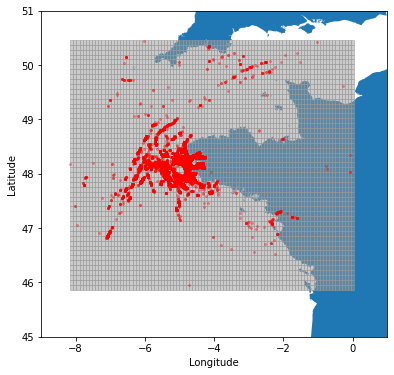

In [4]:
# print grids
ax = utils.createAXNFigure()
BLUE = '#6699cc'
GRAY = '#999999'
for cell in grid:
    ax.add_patch(PolygonPatch(cell["geometry"], fc=GRAY, ec=GRAY, alpha=0.5, zorder=2))

for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Create Grid RDD or DF

In [5]:
grid_df = spark.createDataFrame(grid)
grid_df.printSchema()
print(grid_df.schema)
grid_df.show(10)

gpd_grid_df = gpd.GeoDataFrame(grid)

root
 |-- geometry: geometry (nullable = true)
 |-- grid_id: long (nullable = true)

StructType(List(StructField(geometry,GeometryType,true),StructField(grid_id,LongType,true)))
+--------------------+-------+
|            geometry|grid_id|
+--------------------+-------+
|POLYGON ((-8.1559...|      0|
|POLYGON ((-8.1559...|      1|
|POLYGON ((-8.1559...|      2|
|POLYGON ((-8.1559...|      3|
|POLYGON ((-8.1559...|      4|
|POLYGON ((-8.1559...|      5|
|POLYGON ((-8.1559...|      6|
|POLYGON ((-8.1559...|      7|
|POLYGON ((-8.1559...|      8|
|POLYGON ((-8.1559...|      9|
+--------------------+-------+
only showing top 10 rows



## Link Points tou Grids
- **Approach 1:** Test databricks code for spatial join from link
- **Approach 2:** perform spatial join in order to link points with grids

### Approach 1

def find_intersection(longitude, latitude):
    # row = grid_df.collect()[0]
    # print(row)
    mgdf = gpd_grid_df.apply(lambda x: x.grid_id if x.geometry.intersects(sg.Point(longitude, latitude)) else None, axis=1)
    idx = mgdf.first_valid_index()
    first_valid_value = mgdf.loc[idx] if idx is not None else None
    return int(first_valid_value)

find_intersection_udf = F.udf(find_intersection, IntegerType())


cell_time = time.time()

joined = df_a.withColumn("cell_id", find_intersection_udf(df_a.X, df_a.Y))
joined.show(10)

print("--- %s seconds ---" % (time.time() - cell_time))

### Approach 2

In [6]:
def createPoints(longitude, latitude):
  return sg.Point(longitude, latitude)

createPoints_udf = F.udf(createPoints,GeometryType())

In [7]:
sqlContext = SQLContext(spark)
# timing procedure
start_time = time.time()

geom_df = df_a.withColumn("geometry", createPoints_udf(df_a.X, df_a.Y)).cache()

geom_df.createOrReplaceTempView("points")
grid_df.createOrReplaceTempView("grids")

spatial_join_result = spark.sql(
    """
        SELECT P._id, P.X, P.Y, P.geometry as point_geometry,  G.geometry as grid_geometry, G.grid_id
        FROM points AS P, grids AS G
        WHERE ST_Intersects(P.geometry, G.geometry)
    """
).cache() # cache results to avoid perform join again


spatial_join_result.show()
print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+----------+---------+--------------------+--------------------+-------+
|                 _id|         X|        Y|      point_geometry|       grid_geometry|grid_id|
+--------------------+----------+---------+--------------------+--------------------+-------+
|60039bef2bc024099...|  -4.50088| 48.35698|POINT (-4.50088 4...|POLYGON ((-4.5523...|   2063|
|60039b8f2bc024099...|-4.4970617|48.379555|POINT (-4.4970617...|POLYGON ((-4.5523...|   2063|
|60039bef2bc024099...| -4.500963|48.356915|POINT (-4.500963 ...|POLYGON ((-4.5523...|   2063|
|60039bef2bc024099...| -4.501045|48.356842|POINT (-4.501045 ...|POLYGON ((-4.5523...|   2063|
|60039c032bc024099...|  -4.56926| 48.13976|POINT (-4.56926 4...|POLYGON ((-4.6424...|   2014|
|60039bef2bc024099...| -4.501128|48.356773|POINT (-4.501128 ...|POLYGON ((-4.5523...|   2063|
|60039bef2bc024099...|-4.5012116|  48.3567|POINT (-4.5012116...|POLYGON ((-4.5523...|   2063|
|60039e642bc024099...|-4.5142384|48.369167|POINT (-4.5142384

## Spatial join Approach 2 stats
- find count
- find pings per grid
- filter grids with 0 points

### SOS
Otan kanoume chaining functions mporoume na exoume access se colum apo to proigoumeno function kanontas F.col("coll_name")

In [8]:
print("spatial join count: {}".format(spatial_join_result.count()))

# find pings per grid
filtered_grid = spatial_join_result.groupby(["grid_geometry", "grid_id"])\
    .count()\
    .filter(F.col("count") > 0)\
    .cache()

filtered_grid.show(10)

print("filtered spatial join count: {}".format(filtered_grid.count()))

spatial join count: 112599
+--------------------+-------+-----+
|       grid_geometry|grid_id|count|
+--------------------+-------+-----+
|POLYGON ((-5.4532...|   1561|   10|
|POLYGON ((-4.9127...|   1864|  390|
|POLYGON ((-6.0838...|   1188|    1|
|POLYGON ((-2.4802...|   3219|    8|
|POLYGON ((-5.0928...|   1739|    1|
|POLYGON ((-7.7955...|    232|   10|
|POLYGON ((-5.9937...|   1248|    4|
|POLYGON ((-4.9127...|   1860| 1708|
|POLYGON ((-4.8226...|   1917|   27|
|POLYGON ((-5.4532...|   1550|    2|
+--------------------+-------+-----+
only showing top 10 rows

filtered spatial join count: 405


In [9]:
print("--- TOTAL EXECUTION TIME ---\n--- %s seconds ---" % (time.time() - total_time))

--- TOTAL EXECUTION TIME ---
--- 210.45956110954285 seconds ---


In [ ]:
# print grids
ax = utils.createAXNFigure()
BLUE = '#6699cc'
GRAY = '#999999'
for row in filtered_grid.collect():
    ax.add_patch(PolygonPatch(row["grid_geometry"], fc=GRAY, ec=GRAY, alpha=0.5, zorder=2))

for row in geom_df.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

In [ ]:
print("test")